# Debugging

In [1]:
import numpy as np
import h5py
from matplotlib import pyplot as plt
import stan_utility
import corner

from joint_model_cascades import * 
from aeff_calculator.aeff_calculator import effective_area

/Users/fran/projects/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
random_seed = 19920715

In [3]:
# Use a set of sources uniform in comoving volume for a lambda-CDM universe.
with h5py.File('../data/test_SFR_pop.h5', 'r') as f:
    Ns = f['output/Ns'].value
    redshift = f['output/redshift'].value
    position = f['output/position'].value
    
# Select sources within redshift zth to mimic catalogue
zth = 1.0
selection = np.where(redshift < zth)[0]
Ns = len(selection)
redshift = np.array([redshift[_] for _ in selection])
position = np.array([position[_] for _ in selection])
unit_vector = [p / np.linalg.norm(p) for p in position]

# Add background redshift
redshift = list(redshift) + [zth]

Nsrc = 37


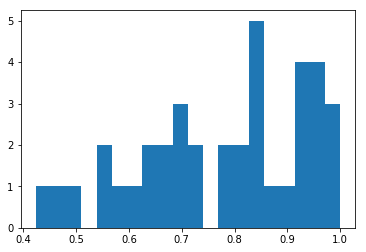

In [4]:
fig, ax = plt.subplots()
ax.hist(redshift, bins=20);
print('Nsrc =', len(redshift)-1)

In [5]:
aeff = effective_area("nue_CC")

... creating effective area spline for interaction nue_CC , done!


(-1.5, 1.5)

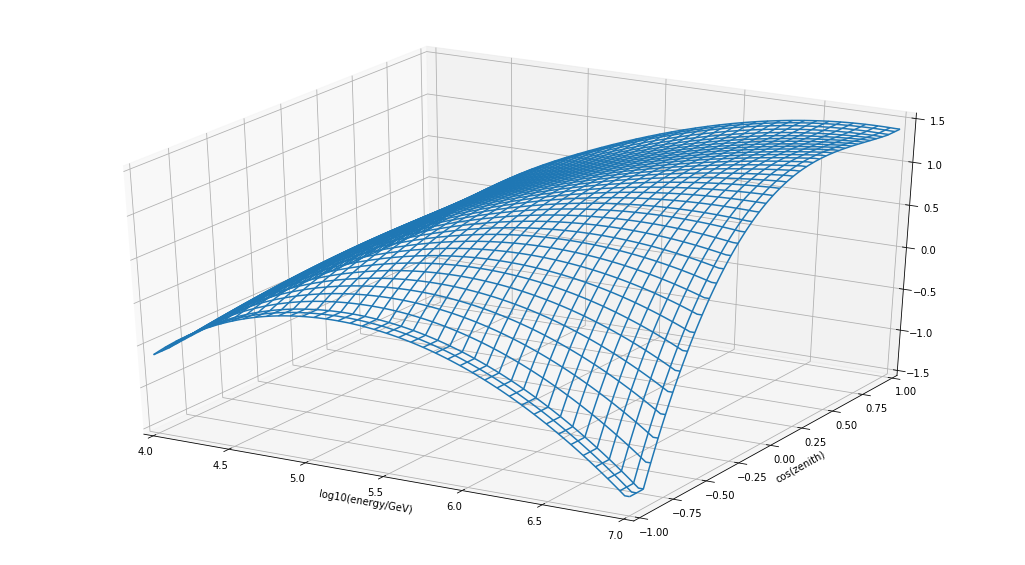

In [6]:
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(4.0, 7.0, 200)
y = np.linspace(-1.0,1.0,200)
xx, yy = np.meshgrid(x, y)
xx = xx.T
yy = yy.T
z = aeff.eval(x, y)

fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_wireframe(xx, yy, z, rstride=5, cstride=5)

ax.set_xlabel('log10(energy/GeV)')
ax.set_ylabel('cos(zenith)')
ax.set_xlim([4.0, 7.0])
ax.set_ylim([-1.0, 1.0])
ax.set_zlim([-1.5, 1.5])

(0, 1.0)

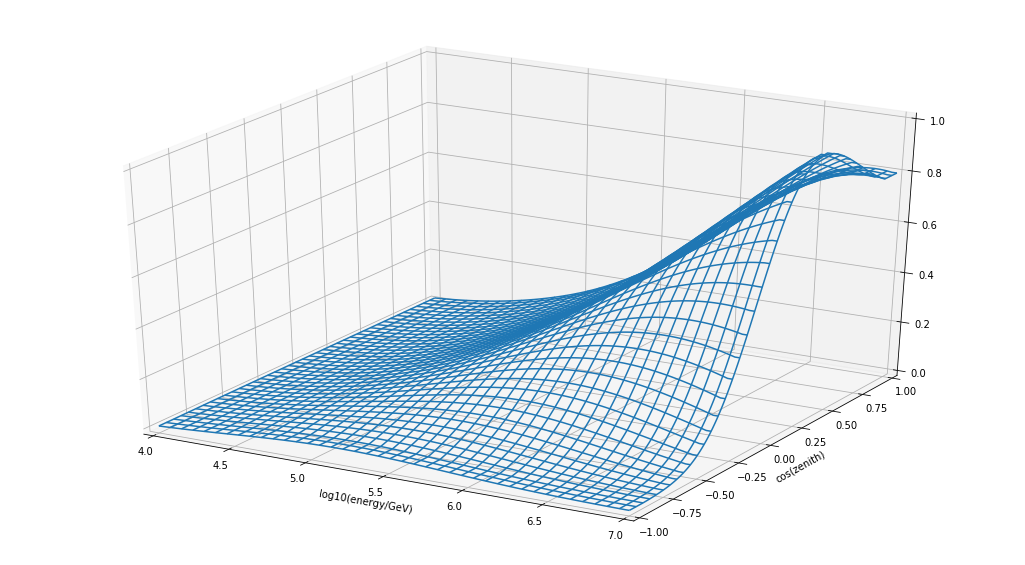

In [18]:
x = np.linspace(4.0, 7.0, 200)
y = np.linspace(-1.0,1.0,200)
xx, yy = np.meshgrid(x, y)
xx = xx.T
yy = yy.T
z = aeff.eval(x, y)

fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_wireframe(xx, yy, 10**z/aeff_max, rstride=5, cstride=5)

ax.set_xlabel('log10(energy/GeV)')
ax.set_ylabel('cos(zenith)')
ax.set_xlim([4.0, 7.0])
ax.set_ylim([-1.0, 1.0])
ax.set_zlim([0, 1.0])

In [117]:
from scipy.interpolate import RectBivariateSpline
my_spline = RectBivariateSpline(x, y, z)

p = 3  # spline degree (default in RectBivariateSpline)
xknots, yknots = my_spline.get_knots()
xknots = np.unique(xknots)
yknots = np.unique(yknots)
Nx = len(xknots)+p-1 
Ny = len(yknots)+p-1 
c = my_spline.get_coeffs()
c = c.reshape(Nx, Ny)
aeff_max = np.max(10**z) # m^2

(-1.5, 2)

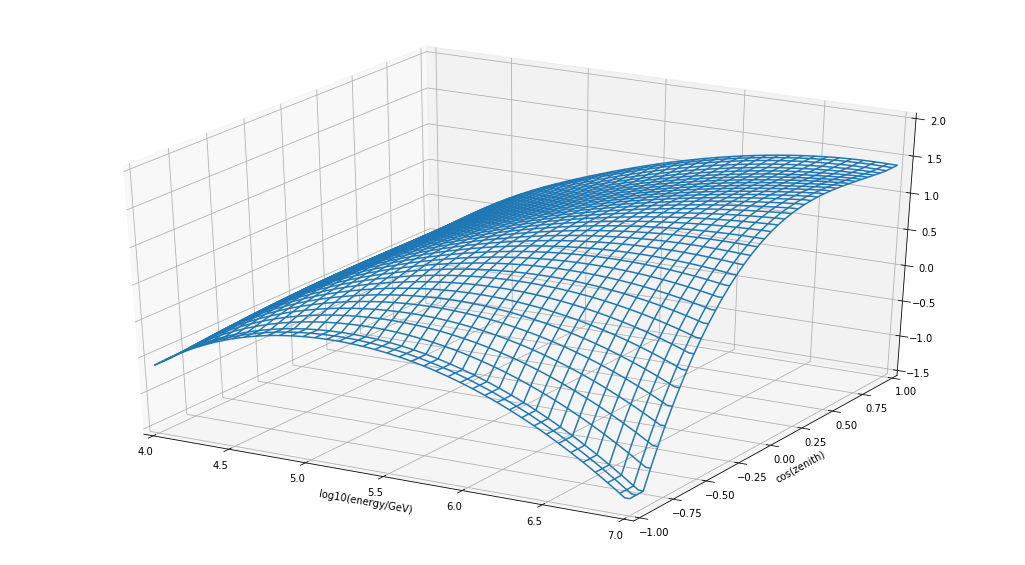

In [118]:
x = np.linspace(4.0, 7.0, 200)
y = np.linspace(-1.0,1.0,200)
xx, yy = np.meshgrid(x, y)
xx = xx.T
yy = yy.T
z = np.zeros((200,200))
for i, _x in enumerate(x):
    for j,_y in enumerate(y):
        z[i][j] = my_spline(_x, _y)[0][0]

fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_wireframe(xx, yy, z, rstride=5, cstride=5)

ax.set_xlabel('log10(energy/GeV)')
ax.set_ylabel('cos(zenith)')
ax.set_xlim([4.0, 7.0])
ax.set_ylim([-1.0, 1.0])
ax.set_zlim([-1.5, 2])

## Simulation to check Aeff effects in cosz

Simulate particles injected with a single $E$ to verify Aeff is working correctly for cosz. 

In [119]:
# Compile Stan model
sim = stan_utility.compile_model(filename = 'stan/aeff_test.stan', 
                                 model_name = 'aeff_test_sim', include_paths = 'stan/')

Using cached StanModel


In [120]:
sim_input = {}
sim_input['N'] = 2000
sim_input['log10E'] = 6.0
sim_input['aeff_max'] = aeff_max

# Spline
sim_input['p'] = p
sim_input['Lknots_x'] = len(xknots)
sim_input['Lknots_y'] = len(yknots)
sim_input['xknots'] = xknots
sim_input['yknots'] = yknots
sim_input['c'] = c

In [121]:
# Simulate
simulation = sim.sampling(data=sim_input, iter=1, chains=1, 
                          algorithm="Fixed_param", seed=random_seed)

In [122]:
# Extract output
from fancy.interfaces.stan import Direction
from fancy.plotting import AllSkyMap

# Arrival directions
event = simulation.extract(['direction'])['direction'][0]
pdet = simulation.extract(['pdet'])['pdet'][0]
zenith = simulation.extract(['zenith'])['zenith'][0]
event = Direction(event)
ra = event.d.icrs.ra.rad
dec = event.d.icrs.dec.rad

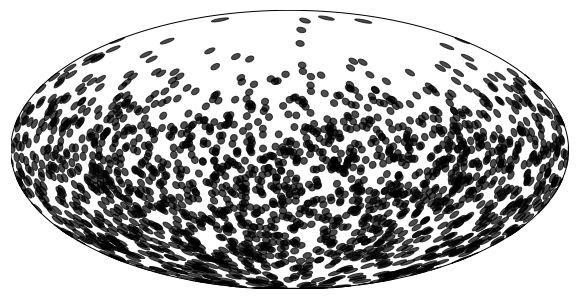

In [123]:
from matplotlib.colors import LinearSegmentedColormap

fig, ax = plt.subplots()
fig.set_size_inches((10, 8))
skymap = AllSkyMap(projection = 'hammer', lon_0=0, lat_0=0);
for r, d in zip(ra, dec):
    skymap.tissot(np.rad2deg(r), np.rad2deg(d), 2, 30, color='k', alpha=0.7)

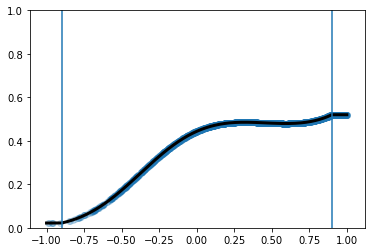

In [124]:
# compare
log10E = sim_input['log10E']
cosz = np.linspace(-1, 1, 1000)
pdet_true = [10**aeff.eval(log10E, _)[0][0] / aeff_max for _ in cosz]

fig, ax = plt.subplots()
ax.plot(cosz, pdet_true, color='k', lw=3)
ax.scatter(np.cos(zenith), pdet, alpha=0.2)
ax.set_ylim(0, 1)
ax.axvline(-0.9)
ax.axvline(0.9)

## Simulation to check Aeff in E
At a single zenith angle, send particles uniformly in energy.

In [125]:
# Compile Stan model
sim = stan_utility.compile_model(filename = 'stan/aeff_test_E.stan', 
                                 model_name = 'aeff_test_E', include_paths = 'stan/')

Using cached StanModel


In [126]:
sim_input = {}
sim_input['N'] = 2000
sim_input['cosz'] = 0.95
sim_input['aeff_max'] = aeff_max

# Spline
sim_input['p'] = p
sim_input['Lknots_x'] = len(xknots)
sim_input['Lknots_y'] = len(yknots)
sim_input['xknots'] = xknots
sim_input['yknots'] = yknots
sim_input['c'] = c

In [127]:
# Simulate
simulation = sim.sampling(data=sim_input, iter=1, chains=1, 
                          algorithm="Fixed_param", seed=random_seed)

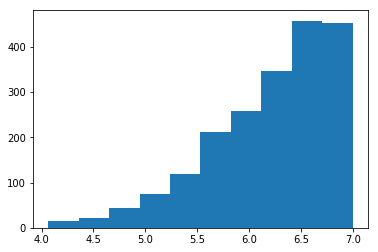

In [128]:
log10E = simulation.extract(['log10E'])['log10E'][0]
pdet = simulation.extract(['pdet'])['pdet'][0]

fig, ax = plt.subplots()
ax.hist(log10E);

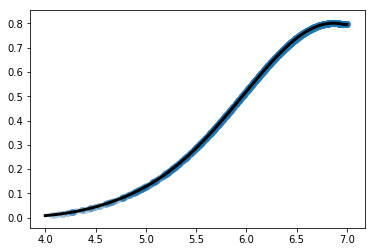

In [129]:
# compare
log10E_true = np.linspace(4.0, 7.0, 1000)
cosz = sim_input['cosz']
pdet_true = [10**aeff.eval(_, cosz)[0][0] / aeff_max for _ in log10E_true]

fig, ax = plt.subplots()
ax.plot(log10E_true, pdet_true, color='k', lw=3)
ax.scatter(log10E, pdet, alpha=0.2)